<a href="https://colab.research.google.com/github/fabianmax/car-classification/blob/master/car_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Select TF2.x as version
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import sys
import pprint
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

from importlib.machinery import SourceFileLoader

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (Dense, 
                                     GlobalAveragePooling2D, 
                                     Flatten, 
                                     Conv2D, 
                                     MaxPool2D, 
                                     Input, 
                                     Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

In [3]:
# Mount Google Drive for data
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!git clone https://github.com/fabianmax/car-classification.git
!mkdir car-classification/data
!mkdir car-classification/data/raw
!cp drive/My\ Drive/Car-Classifier/data/zip/car-classifier-raw.zip car-classification/data
!unzip -q car-classification/data/car-classifier-raw.zip -d car-classification/data/raw

Cloning into 'car-classification'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 178 (delta 109), reused 117 (delta 55), pack-reused 0
Receiving objects: 100% (178/178), 36.76 KiB | 1.75 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [5]:
#ROOT = '/content/drive'
#PROJECT = 'My Drive/Car-Classifier'
#PROJECT_PATH = os.path.join(ROOT, PROJECT)
PROJECT_PATH = 'car-classification'
print(f'Project directory is {PROJECT_PATH}')
ACCELERATOR = 'GPU'

# Set working dir
os.chdir(PROJECT_PATH)

Project directory is car-classification


In [6]:
# Pull latest files from github
!git pull

sys.path.append(os.getcwd())

# Sources python files from Google Drive
car_classifier_pipeline = SourceFileLoader('car_classifier', 
                                           'car_classifier/pipeline.py').load_module()

car_classifier_model = SourceFileLoader('car_classifier', 
                                        'car_classifier/modeling.py').load_module()

car_classifier_utils = SourceFileLoader('car_classifier', 
                                        'car_classifier/utils.py').load_module()                                     

Already up to date.


In [0]:
def test_files():
  """
  Test if all files present 
  """
  files = os.listdir(INPUT_DATA_DIR)
  assert len(files) == 64467, f'Found {len(files)} but expected 64467 files.'

def test_tpu():
  """
  Test if TPU usage is possible
  """
  if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime; \
    please see the first cell in this notebook for instructions!')
  else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print ('TPU address is', tpu_address)

  with tf.compat.v1.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

def test_gpu():
  """
  Test if GPU usage is possible
  """
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

In [0]:
# Gobal settings
INPUT_DATA_DIR = 'data/raw/car-classifier-raw/'
CHECKPOINT_DIR = '/content/drive/My Drive/Car-Classifier/checkpoints/'
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
TARGET = 'make'
BASE = 'ResNet'

In [9]:
# Test files
test_files()

# Test GPU/TPU
if ACCELERATOR == 'TPU':
  test_tpu()
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
elif ACCELERATOR == 'GPU':
  test_gpu()

Found GPU at: /device:GPU:0


In [0]:
# All available training images
files = [file for file in os.listdir(INPUT_DATA_DIR) if file.endswith(".jpg")]
file_paths = [INPUT_DATA_DIR + file for file in files]

# Create a list of all possible outcomes
if TARGET == 'make':
    classes = list(set([file.split('_')[0] for file in files]))
if TARGET == 'model':
    classes = list(set([file.split('_')[0] + '_' + file.split('_')[1] for file in files]))

classes_lower = [x.lower() for x in classes]

# Split paths into train, valid, and test
files_train, files_test = train_test_split(file_paths, test_size=0.25)
files_train, files_valid = train_test_split(files_train, test_size=0.25)

# Construct tf.data.Dataset from file paths
ds_train = car_classifier_pipeline.construct_ds(input_files=files_train, 
                                                batch_size=BATCH_SIZE, 
                                                classes=classes_lower, 
                                                input_size=INPUT_SHAPE, 
                                                prefetch_size=BATCH_SIZE*10,
                                                augment=True)

ds_valid = car_classifier_pipeline.construct_ds(input_files=files_valid, 
                                                batch_size=BATCH_SIZE, 
                                                classes=classes_lower, 
                                                input_size=INPUT_SHAPE, 
                                                prefetch_size=BATCH_SIZE*10,
                                                augment=False)

ds_test = car_classifier_pipeline.construct_ds(input_files=files_test, 
                                               batch_size=BATCH_SIZE, 
                                               classes=classes_lower, 
                                               input_size=INPUT_SHAPE, 
                                               prefetch_size=BATCH_SIZE*10,
                                               augment=False)

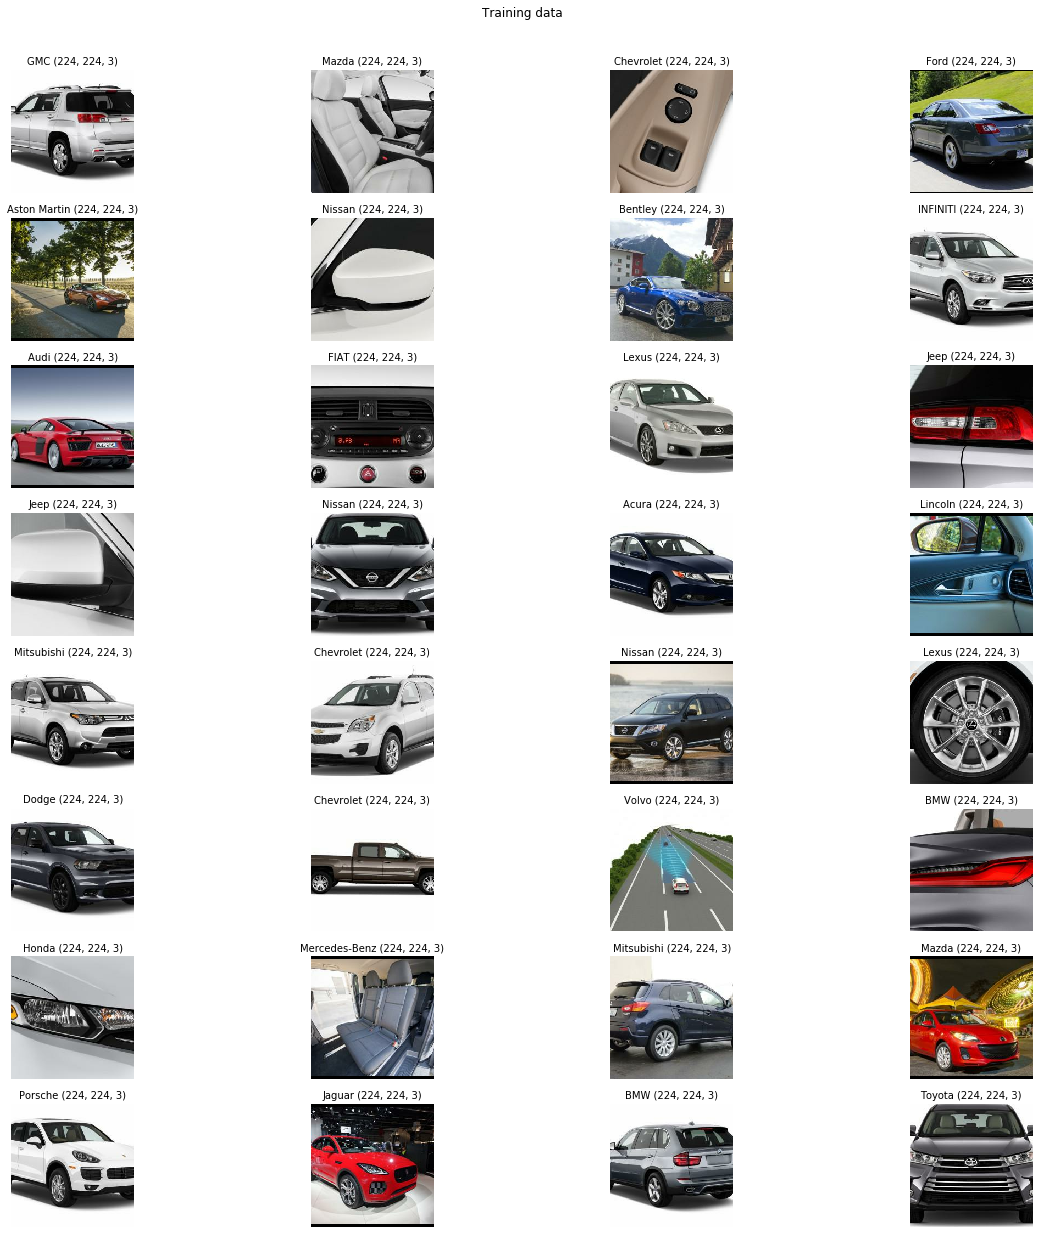

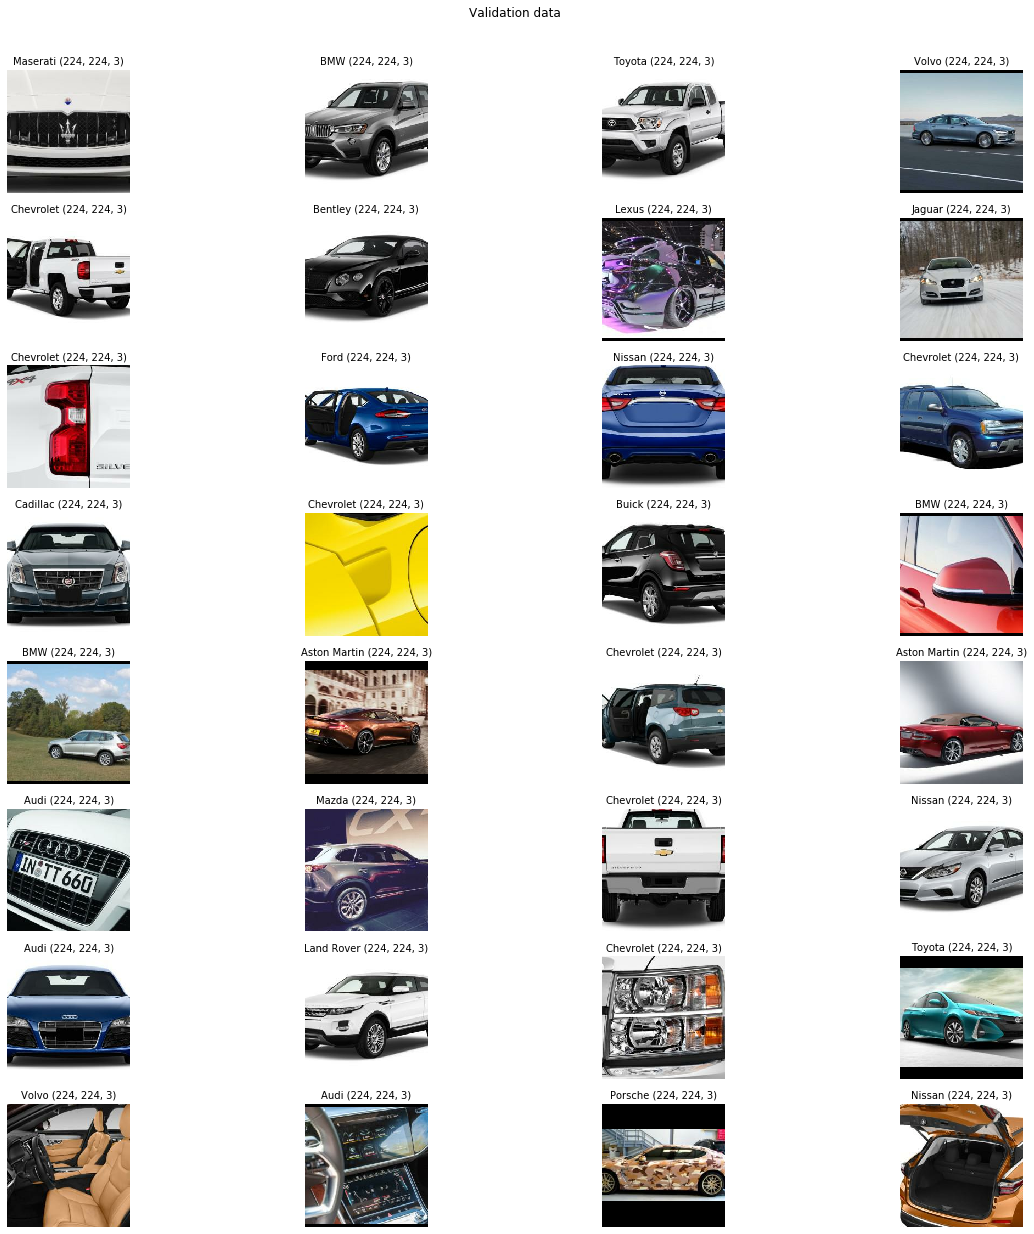

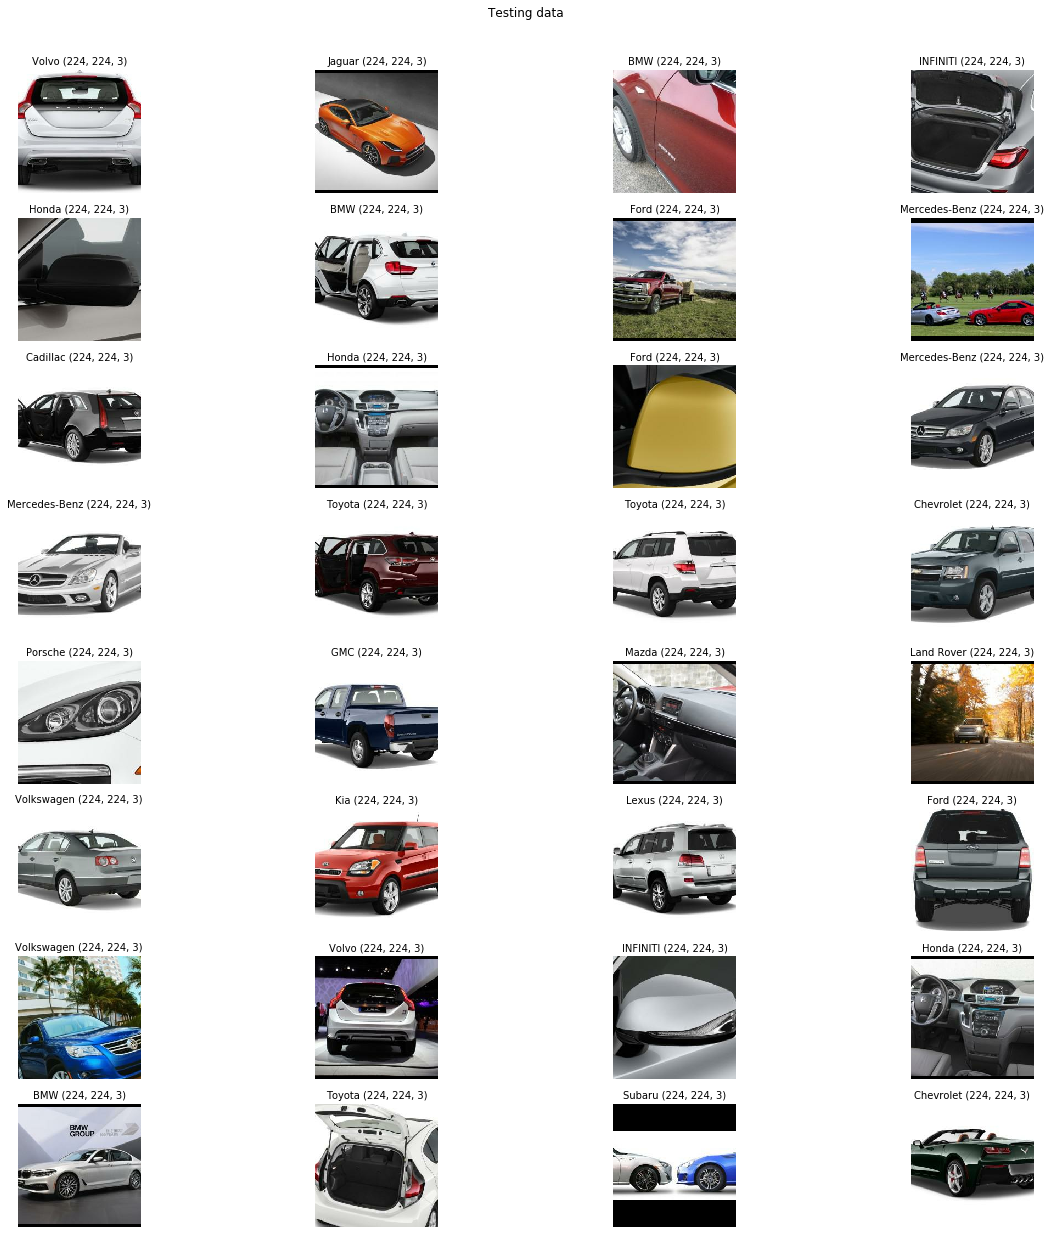

In [11]:
# Show examples from one batch
plot_size = (18, 18)

car_classifier_utils.show_batch(ds_train, classes, size=plot_size, title='Training data')
car_classifier_utils.show_batch(ds_valid, classes, size=plot_size, title='Validation data')
car_classifier_utils.show_batch(ds_test, classes, size=plot_size, title='Testing data')

In [0]:
# Overview over class distribution after splitting
def get_class_counts(files):
  """
  Get class label count from file paths
  """
  return(pd.Series([file.split('/')[3].split('_')[0] for file in files]).value_counts())

class_counts_train = get_class_counts(files_train)
class_counts_valid = get_class_counts(files_valid)
class_counts_test = get_class_counts(files_test)

class_distribution = pd.concat([class_counts_train.rename('train'), 
                                class_counts_valid.rename('valid'), 
                                class_counts_test.rename('test')], 
                               axis=1,
                               sort=False)

#print(class_distribution)

Train for 1134 steps, validate for 378 steps
Epoch 1/3
1134/1134 [==============================] - 770s 679ms/step - loss: 2.1919 - categorical_accuracy: 0.4137 - val_loss: 1.5114 - val_categorical_accuracy: 0.5875
Epoch 2/3
1134/1134 [==============================] - 764s 673ms/step - loss: 1.1103 - categorical_accuracy: 0.6980 - val_loss: 1.3095 - val_categorical_accuracy: 0.6545
Epoch 3/3
1134/1134 [==============================] - 763s 673ms/step - loss: 0.6781 - categorical_accuracy: 0.8136 - val_loss: 1.2528 - val_categorical_accuracy: 0.6774


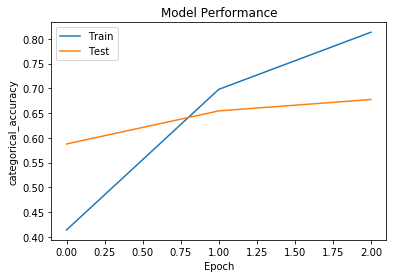

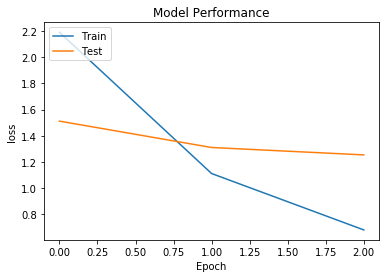

504/504 [==============================] - 100s 197ms/step - loss: 1.2536 - categorical_accuracy: 0.6787


{'categorical_accuracy': 0.6786623, 'loss': 1.2535776854270981}

In [20]:
# Initialize base model and compile
model = car_classifier_model.TransferModel(base=BASE, shape=INPUT_SHAPE, classes=classes, unfreeze='all')
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(0.0001),
              metrics=["categorical_accuracy"])

# Train model
model.train(ds_train=ds_train, ds_valid=ds_valid, epochs=3)

# Plot loss/accuracy on training and validation data sets
model.plot(what='metric')
model.plot(what='loss')

# Evaluate performance on testing data
model.evaluate(ds_test=ds_test)

In [27]:
# Save model
named_tuple = time.localtime() # get struct_time
timestamp = time.strftime("%m%d%Y_%H%M%S", named_tuple) 
evaluation = model.evaluate(ds_test=ds_test)

model.save(CHECKPOINT_DIR + 'model_' + timestamp + '_' + str(evaluation['categorical_accuracy']).replace('.', '_') + '.h5')

504/504 [==============================] - 101s 200ms/step - loss: 1.2531 - categorical_accuracy: 0.6787


In [28]:
# Test restoring model
del model

model_path = '/content/drive/My Drive/Car-Classifier/checkpoints/model_03092020_161854_0_6786623.h5'

model = car_classifier_model.TransferModel(base=BASE, shape=INPUT_SHAPE, classes=classes, unfreeze='all')
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(0.0001),
              metrics=["categorical_accuracy"])

model.load(model_path)

model.evaluate(ds_test=ds_test.take(4))

4/4 [==============================] - 2s 459ms/step - loss: 1.6847 - categorical_accuracy: 0.6250


{'categorical_accuracy': 0.625, 'loss': 1.6847184747457504}

## Benchmark Network

In [0]:
# Basic CNN for benchmark
# Gets to around 50% accuracy after ~20 Epochs
# Overfitting on loss starts to occur after ~15 Epochsd
model = Sequential()
model.add(Input(INPUT_SHAPE))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(0.0001),
              metrics=["categorical_accuracy"])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=10,
                               restore_best_weights=True)

callbacks = [early_stopping]

history = model.fit(ds_train,
                    epochs=100,
                    validation_data=ds_valid,
                    callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 359552)            0

KeyboardInterrupt: ignored

In [0]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

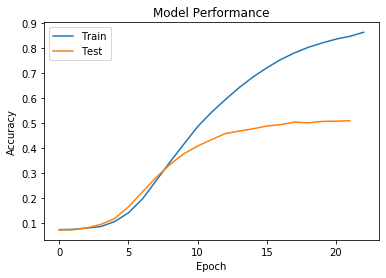

In [0]:
plt.plot(model.history.history['categorical_accuracy'])
plt.plot(model.history.history['val_categorical_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
n_batches = 10

train_batches = ds_train.take(n_batches)
valid_batches = ds_valid.take(n_batches)
test_batches = ds_test.take(n_batches)

y_train_p = model.predict(train_batches)
y_valid_p = model.predict(valid_batches)
y_test_p = model.predict(test_batches)

y_train_pred = [np.argmax(x) for x in y_train_p]
y_valid_pred = [np.argmax(x) for x in y_valid_p]
y_test_pred = [np.argmax(x) for x in y_test_p]

y_train_true = np.array([])
y_valid_true = np.array([])
y_test_true = np.array([])

for img, lab in train_batches.as_numpy_iterator():
    y_true = np.argmax(lab, axis=1)
    y_train_true = np.concatenate((y_train_true, y_true))

for img, lab in valid_batches.as_numpy_iterator():
    y_true = np.argmax(lab, axis=1)
    y_valid_true = np.concatenate((y_valid_true, y_true))

for img, lab in test_batches.as_numpy_iterator():
    y_true = np.argmax(lab, axis=1)
    y_test_true = np.concatenate((y_test_true, y_true))

In [0]:
# Training
with np.printoptions(threshold=np.inf):
    print(confusion_matrix(y_train_true, y_train_pred).diagonal())

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [0]:
# Testing
with np.printoptions(threshold=np.inf):
    print(confusion_matrix(y_test_true, y_test_pred).diagonal())

[ 0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]


In [0]:
probs_by_class_train = pd.melt(pd.DataFrame(y_train_p), value_name='prob', var_name='class')
probs_by_class_valid = pd.melt(pd.DataFrame(y_valid_p), value_name='prob', var_name='class')
probs_by_class_test = pd.melt(pd.DataFrame(y_test_p), value_name='prob', var_name='class')

probs_by_class_train['type'] = 'train'
probs_by_class_valid['type'] = 'valid'
probs_by_class_test['type'] = 'test'

compare_probs_df = pd.concat([probs_by_class_train,
                              probs_by_class_valid,
                              probs_by_class_test],
                             axis=0,
                             ignore_index=True)


g = sns.FacetGrid(compare_probs_df, col='type', row='class')
g = g.map(plt.hist, "prob")

NameError: ignored